# Analyzing Trajectories

## Overview

### Questions

* How can I analyze trajectories?

### Objectives

* Describe how to access trajectory frames in **GSD**.
* Examine the trajectory with **freud** and **fresnel**.

## Boilerplate Code

In [1]:
import math

import freud
import gsd.hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

The `render` function in the next (hidden) cell will render a snapshot using **fresnel**.
`render_movie` will render a sequence of frames as an animated GIF.
These methods accept a *particles* argument that filters out which particles to display.
Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [2]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import io
import warnings

import fresnel
import IPython
import numpy
import packaging.version
import PIL

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(snapshot, particles=None, is_solid=None):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=N)
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        geometry.orientation[:] = snapshot.particles.orientation[:]
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        geometry.orientation[:] = snapshot.particles.orientation[particles, :]
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[
            numpy.ix_(is_solid, [0, 1, 2])
        ]
        geometry.orientation[:] = snapshot.particles.orientation[
            numpy.ix_(is_solid, [0, 1, 2, 3])
        ]

    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)


def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        'P', palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f'Large GIF: {size} KiB')
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

## Equilibration Challenges

In the previous section, you ran the hard octahedra system for many time steps to **equilibrate** it and saved the trajectory in `trajectory.gsd`.
Is the final **state** you obtained actually an **equilibrium state**?
Statistical mechanics tells us that as long as our system is *ergodic* it will *eventually* achieve equilibrium.
You need to analyze this trajectory to determine if you have achieved the ordered **equilibrium** structure.

## Tools

There are many tools that can read **GSD** files and analyze or visualize the simulations, and many more Python packages that can work with the numerical data.
This tutorial will show you how to use **freud** to determine which particles are in a solid-like environment and **fresnel** to render system configurations.
The [freud](https://freud.readthedocs.io/) Python package provides a simple, flexible, powerful set of tools for analyzing trajectories obtained from molecular dynamics or Monte Carlo simulations.
The [fresnel](https://fresnel.readthedocs.io/) Python package produces publication quality renders with soft lighting, depth of field and other effects.

While outside the scope of this tutorial, you might want to use tools such as [OVITO](https://www.ovito.org/) or [VMD](https://www.ks.uiuc.edu/Research/vmd/) to visualize the trajectory interactively.
OVITO has built-in support for **GSD** files.
The [gsd-vmd](https://github.com/mphowardlab/gsd-vmd) plugin adds support to VMD.

## Read the Trajectory

Use **GSD** to open the **trajectory** generated by the previous section of this tutorial.

In [3]:
traj = gsd.hoomd.open('trajectory.gsd')

You can index into the frames of the trajectory like a list.
See how many frames exist in the trajectory:

In [4]:
len(traj)

105

## Ergodicity

A system is *ergodic* when it can explore all possible states by making small moves from one to another.
In HPMC simulations, low volume fraction simulations are ergodic while very high volume fraction ones are not.
At high volume fractions, there isn't enough free space for the particles to rearrange so they get stuck in local configurations.

Visualize the motion of just a few particles to see if they appear stuck or if they are freely moving about the box:

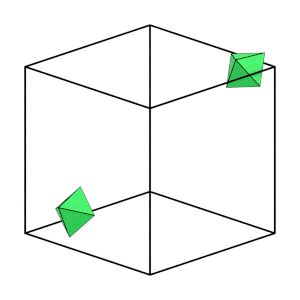

In [5]:
render_movie(traj[0:50:5], particles=[12, 18])

Good!
Over the first part of the simulation (while the system is still fluid), individual particles are able to move a significant distance and explore many different orientations.
This indicates that our system is *ergodic*.

## Simulation Length

How can you tell if you have run long enough to **equilibrate** the system?
The hard octahedra system forms the bcc structure [by nucleation and growth](https://doi.org/10.1038/ncomms14038).
Nucleation is a rare event, so you need to keep running the simulation until it occurs.
If you ran this simulation many times with different random seeds, each would take a different number of steps to nucleate.
You need to examine the simulation trajectory in detail to determine if you have run it long enough.

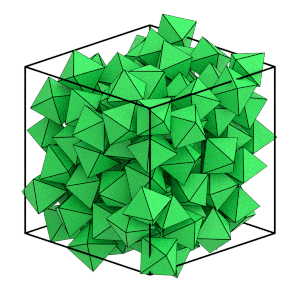

In [6]:
render_movie(traj[0:100:12])

Can you see the system ordering?
The orientations of the octahedra appear to quickly snap to face the same direction and the particle positions line up on evenly spaced planes.
You can use **freud's SolidLiquid** analysis method to quantitatively identify which particles are in the solid structure.

Loop over all of the frames in the file and create a boolean array that indicates which particles are in a solid environment:

In [7]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=8),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

Plot the total number of particles in a solid environment over time:

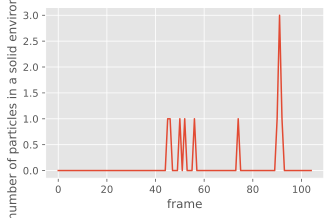

In [8]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

This plot confirms what you saw visually and what you should expect in a system that nucleates and grows a crystal.
There is no solid at the beginning of the simulation.
Then a solid cluster forms and grows to fill the box.

Visualize just the solid particles to see this more clearly:

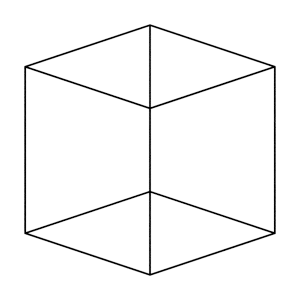

In [9]:
start_frame = int(numpy.argmax(num_solid > 4))
end_frame = int(numpy.argmax(num_solid == numpy.max(num_solid)))
step = int((end_frame - start_frame) / 6)
render_movie(
    traj[start_frame:end_frame:step], is_solid=is_solid[start_frame:end_frame:step]
)

This is the end of the first tutorial!
It covered the core HOOMD-blue objects, described hard particle Monte Carlo simulations, and demonstrated how to initialize, randomize, compress, equilibrate, and analyze a system of self-assembling hard octahedra.
See the other HOOMD-blue tutorials to learn about other concepts, or browse the reference documentation for more information.

[Previous section](06-Equilibrating-the-System.ipynb). [Tutorial index](../README.md).